In [208]:
# Install required libraries
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [209]:
# Read the CSV file into a DataFrame
df = pd.read_csv('output.csv')

# Convert string represntations of Python dictionaries back into the correct data type
df['market_values'] = df['market_values'].apply(ast.literal_eval)
df['sales_prices'] = df['sales_prices'].apply(ast.literal_eval)

# Display the DataFrame
df

,address,square_feet,market_values,sales_prices
0,915 PEDALERS LN,1256.0,"{2023: 398000, 2022: 343000}",{2021: 335000}
1,917 PEDALERS LN,1122.0,"{2023: 375500, 2022: 324000}",{2021: 318000}
2,919 PEDALERS LN,1180.0,"{2023: 385500, 2022: 332500}",{2021: 321000}
3,921 PEDALERS LN,1194.0,"{2023: 411000, 2022: 316000}","{2022: 410000, 2021: 308000}"
4,923 PEDALERS LN,1136.0,"{2023: 378500, 2022: 326500}",{2021: 326000}
...,...,...,...,...
153,1040 SW 16TH ST,1938.0,{},{}
154,1044 SW 16TH ST,1820.0,{2023: 633500},{2022: 632500}
155,1048 SW 16TH ST,2292.0,{},{}
156,1052 SW 16TH ST,752.0,{},{2023: 523500}


In [210]:
# Create new columns for 'price/square foot' and 'value change'

# Extract the most recent sales price and market value
get_most_recent = lambda x: next(iter(x.values())) if x else None
df['most_recent_sales_price'] = df['sales_prices'].apply(get_most_recent)
df['most_recent_market_value'] = df['market_values'].apply(get_most_recent)

# Calculate price/square foot
df['price/square_foot'] = df['most_recent_sales_price'] / df['square_feet']

# Calculate value change
df['value_change'] = df['most_recent_market_value'] - df['most_recent_sales_price']

# Display the DataFrame
df


,address,square_feet,market_values,sales_prices,most_recent_sales_price,most_recent_market_value,price/square_foot,value_change
0,915 PEDALERS LN,1256.0,"{2023: 398000, 2022: 343000}",{2021: 335000},335000.0,398000.0,266.719745,63000.0
1,917 PEDALERS LN,1122.0,"{2023: 375500, 2022: 324000}",{2021: 318000},318000.0,375500.0,283.422460,57500.0
2,919 PEDALERS LN,1180.0,"{2023: 385500, 2022: 332500}",{2021: 321000},321000.0,385500.0,272.033898,64500.0
3,921 PEDALERS LN,1194.0,"{2023: 411000, 2022: 316000}","{2022: 410000, 2021: 308000}",410000.0,411000.0,343.383585,1000.0
4,923 PEDALERS LN,1136.0,"{2023: 378500, 2022: 326500}",{2021: 326000},326000.0,378500.0,286.971831,52500.0
...,...,...,...,...,...,...,...,...
153,1040 SW 16TH ST,1938.0,{},{},NaN,NaN,NaN,NaN
154,1044 SW 16TH ST,1820.0,{2023: 633500},{2022: 632500},632500.0,633500.0,347.527473,1000.0
155,1048 SW 16TH ST,2292.0,{},{},NaN,NaN,NaN,NaN
156,1052 SW 16TH ST,752.0,{},{2023: 523500},523500.0,NaN,696.143617,NaN


MSE: 5371364089.761029
RMSE: 73289.59059621653
R2: 0.8450554284322387


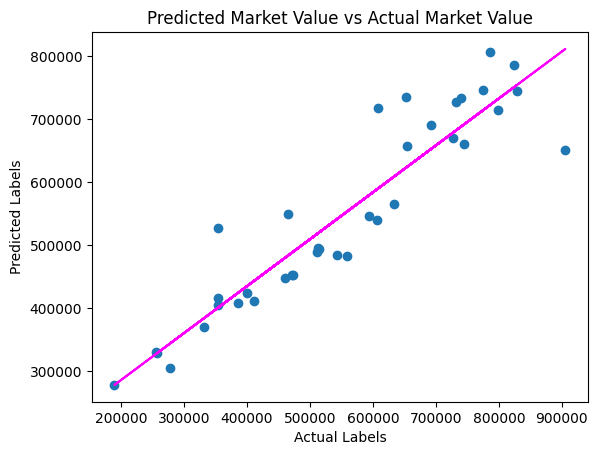

In [211]:
# Clean the data and break into features and labels
cleaned_df = df.dropna(subset=['square_feet', 'most_recent_market_value'])
X = cleaned_df[['square_feet']].values
y = cleaned_df['most_recent_market_value'].values

# Split data into training/testing groups and create a model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
market_model = LinearRegression().fit(X_train, y_train)
predictions = market_model.predict(X_test)

# Determine how well the model predicts
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Predicted Market Value vs Actual Market Value')

# Overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

In [212]:
# Predict market value of a 1,700 square feet home
print(market_model.predict([[1700]])[0])

535497.4510519048


MSE: 8009908768.273759
RMSE: 89498.09365720456
R2: 0.8150415068098573


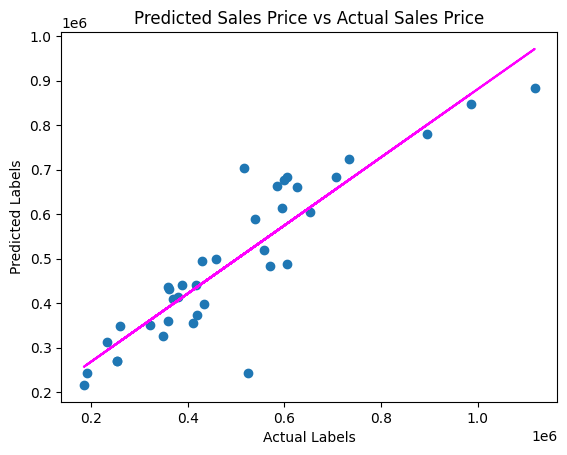

In [213]:
# Clean the data and break into features and labels
cleaned_df = df.dropna(subset=['square_feet', 'most_recent_sales_price'])
X = cleaned_df[['square_feet']].values
y = cleaned_df['most_recent_sales_price'].values

# Split data into training/testing groups and create a model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
sales_model = LinearRegression().fit(X_train, y_train)
predictions = sales_model.predict(X_test)

# Determine how well the model predicts
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Predicted Sales Price vs Actual Sales Price')

# Overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

In [214]:
# Predict sales price of a 1,700 square feet home
print(sales_model.predict([[1700]])[0])

484195.0137615993
